# Introduction to Climate Networks for global 2m air temperature anomalies

## Data loading

In [2]:
# imports needed
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import plot_utils as put
import scipy.stats as st
import networkx as nx  # For network analysis
import networkit as nk  # For community detection
from importlib import reload

In [3]:
ds = xr.open_dataset('./data/era5_t2m_2.5_monmean_ds.nc')
# Just executing the dataset will give you a first overview over the dataset
ds

<xarray.Dataset>
Dimensions:  (time: 492, lat: 73, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 174.7 177.2 179.8
Data variables:
    t2m      (time, lat, lon) float32 ...

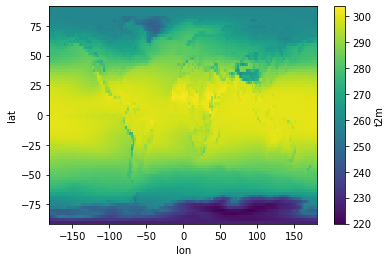

In [4]:
# Get a first impression of the data. Are they meaningful?
var_name = 't2m'  # This is the name of the climate variable = 2 meter air temperature
ds[var_name].mean(dim='time').plot()

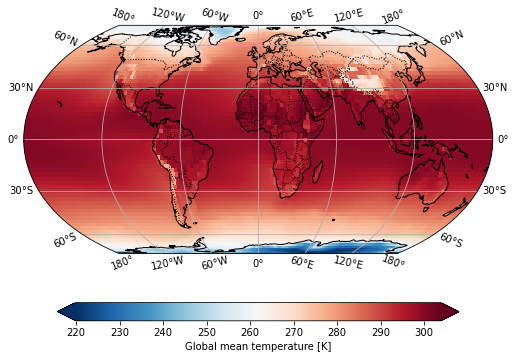

In [5]:
reload(put)
mean_t2m = ds[var_name].mean(dim='time')
im = put.plot_map(mean_t2m, label='Global mean temperature [K]', projection='EqualEarth')

## Preprocess Data

### Detrend data and create anomaly time series
Plot the average global mean temperature: Why do we see an increase?

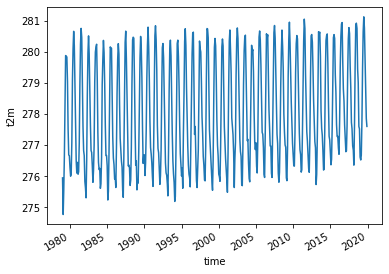

In [6]:
# Plot the average yearly temperature
# What might be the problem?
ds[var_name].mean(dim='lon').mean('lat').plot()

In the data we want to avoid correlations that arise due to the seasonal cycle. 
Therefore we compute anomaly time series in each cell.
The anomaly of a variable is the variation relative to the climatological mean.
Climatological means can be based on the day of the year, month, season, year etc ...
The mean is the long-term average of the same variable. We use it as a baseline value. 
The anomaly values are therefore the original values - climatology 

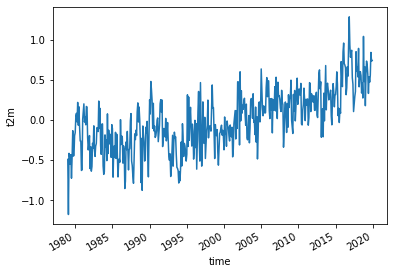

In [7]:
# Compute anomaly time series 
group = 'dayofyear'
climatology = (
            ds[var_name].groupby(f"time.{group}").mean(dim="time")
        )
anomalies = ds[var_name].groupby(f"time.{group}") - climatology
anomalies.mean(dim='lon').mean('lat').plot()

We have seen that we need to detrend the data.
We do this by computing in each cell the trend and substract it then from the original dataset.
The resulting dataset is then plotted.

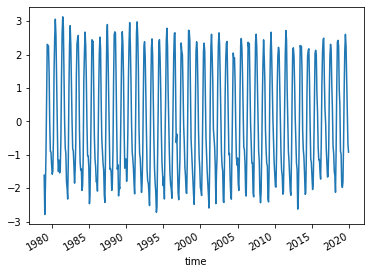

In [8]:
# Compute the fit coefficients
p = ds[var_name].polyfit(dim='time', deg=1)
# Apply the fit
fit = xr.polyval(ds['time'], p.polyfit_coefficients)
da_detrend = ds[var_name] - fit  # Substract the linear increase from the actual data
da_detrend.mean(dim='lon').mean('lat').plot()


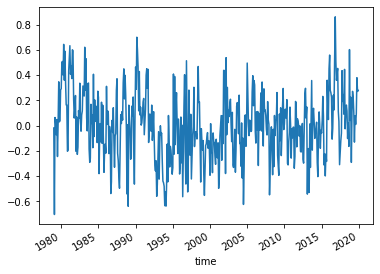

In [9]:
# Now compute anomaly time series 
group = 'dayofyear'
climatology = (
            da_detrend.groupby(f"time.{group}").mean(dim="time")
        )
anomalies = da_detrend.groupby(f"time.{group}") - climatology
anomalies.mean(dim='lon').mean('lat').plot()
ds['anomalies'] = anomalies


## Now compute all pair-wise correlations

In [11]:
da = ds['anomalies']  # Use the anomaly data to compute the pairwise correlations
print('Dataset shape: ', da.shape)
dim_time, dim_lat, dim_lon = da.shape
# Bring all into a form of an array of time series
data = []
data = []
for idx, t in enumerate(da.time):
        buff = da.sel(time=t.data).data.flatten()  # flatten each time step
        buff[np.isnan(buff)] = 0.0  # set missing data to climatology
        data.append(buff)
data = np.array(data)
print('Flattend Dataset shape: ', data.shape)
corr, pvalue =  st.spearmanr(
        data, axis=0, nan_policy='propagate')
print('Shape of correlation Matrix: ', corr.shape)


Dataset shape:  (492, 73, 144)
Flattend Dataset shape:  (492, 10512)


Shape of correlation Matrix:  (10512, 10512)


Not all correlations are statistically significant.
Let's first exclude non-significant correlations

In [13]:
confidence = 0.999
mask_confidence = np.where(pvalue <= (1 - confidence), 1, 0)  # p-value test
corr = np.where(mask_confidence==1, corr, 0)

In [14]:
# get minimum value that is still accounted as a correlation
# Do you think this is fine?
np.nanmin(np.where(np.abs(corr) != 0, np.abs(corr), np.nan))

0.14790797759462537

Now finally compute the adjacency matrix of the network

In [15]:
threshold = 0.4  # absolute threshold for correlations
mask_correlation = np.where(np.abs(corr) >= threshold, 1, 0)

# A link in the adjacency is placed for all significant values above the threshold
adjacency = mask_confidence * mask_correlation

# Obtain sparsity of adjacency matrix.
sparsity = (
    np.count_nonzero(adjacency.flatten()) / adjacency.shape[0]**2
)
print("Sparsity of adjacency: ", sparsity)

Sparsity of adjacency:  0.022751341367638983


In [49]:
# Use networkx for better using dealing with the adjacency matrix
import networkx as nx
cnx = nx.DiGraph(adjacency)


In [55]:
# Set the longitude and latitude as node attributes
lons = ds.lon
lats = ds.lat
lon_mesh, lat_mesh = np.meshgrid(lons, lats)

nx.set_node_attributes(cnx, {node: lon_mesh.flatten()[node] for node in cnx.nodes()}, 'lon')
nx.set_node_attributes(cnx, {node: lat_mesh.flatten()[node] for node in cnx.nodes()}, 'lat')


In [58]:
cnx.nodes[1000]

{'lon': 162.13986013986016, 'lat': -75.0}

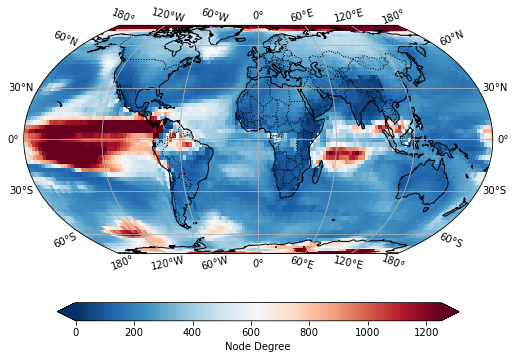

In [17]:
reload(put)
degrees = {node: val for (node, val) in cnx.degree()}
nx.set_node_attributes(cnx, degrees, "degree")
# Plot degrees
degree_arr = np.array(list(degrees.values())).reshape(dim_lat, dim_lon)
degree_map = put.create_map_for_da(da=ds[var_name], data=degree_arr, name='degree')
im = put.plot_map(degree_map, 
                  label='Node Degree', 
                  projection='EqualEarth',
                  vmin=0,
                  vmax=1250)

### Visualize single edges of the network

In [29]:
# Find out the nodes of the source region
lat_range = [-10, -15]
lon_range = [60,65]
# Why is this masked needed?
mask = (
        (degree_map['lat'] >= min(lat_range))
        & (degree_map['lat'] <= max(lat_range))
        & (degree_map['lon'] >= min(lon_range))
        & (degree_map['lon'] <= max(lon_range))
        )
source_map = xr.where(mask, 1, np.nan)
# source_map.plot()

# Get Ids of locations
source_ids = np.where(source_map.data.flatten()==1)[0]  # flatten data and get position in array

# Find target Ids in the network
edge_list = []
for sid in source_ids:
        edge_list.append(list(cnx.edges(sid)))

edge_list = np.concatenate(edge_list, axis=0)  # transform to 2d np array

251

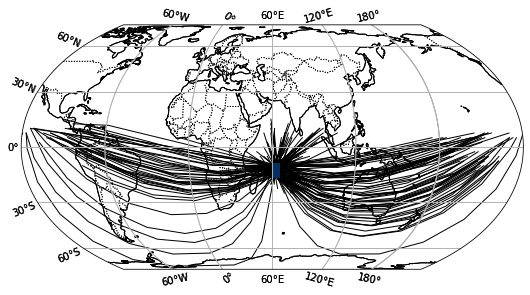

In [69]:
reload(put)
im = put.plot_map(source_map, bar=False, central_longitude=60)
put.plot_edges(cnx=cnx, edges=edge_list[::10], ax=im['ax'])  # Plot every 10th 


## Community detection in climate Networks
Here we use the standard [Louvain algorithm](https://en.wikipedia.org/wiki/Louvain_method).
It basically optimizes local density of edges to cluster a given graph into communities. 

In [71]:
cnk = nk.nxadapter.nx2nk(cnx.to_undirected())  # nk algorithm needs the nx network as nk object

In [78]:
# Use the Parallel Louvain Method (PLM) of NetworkIt
nkCommunities = nk.community.detectCommunities(
            cnk, algo=nk.community.PLM(cnk, True)
        )
CommunityIds = np.array(nkCommunities.getVector())

Communities detected in 0.07845 [s]
solution properties:
-------------------  -----------
# communities           7
min community size   1057
max community size   2330
avg. community size  1501.71
modularity              0.747577
-------------------  -----------


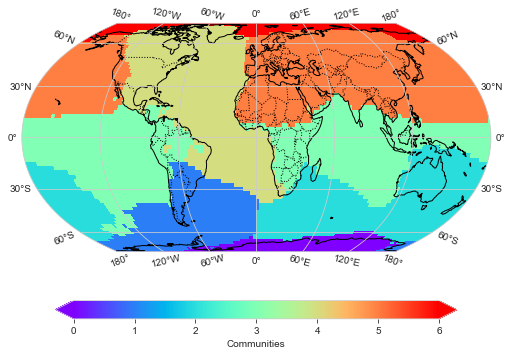

In [81]:
community_map = put.create_map_for_da(da=ds[var_name], data=CommunityIds.reshape(dim_lat, dim_lon), name='Communities')
im = put.plot_map(community_map, bar=True, 
                  cmap='rainbow',
                  central_longitude=0)

## Clustering of climate data
Compute the clusters of based on complete linkage clustering of the Spearman's Correlation Matrix!
We follow the method from Rheinwalt et al. 2015

In [127]:
def get_distance(corr, pvalue, confidence=0.001, threshold=None):
    """Get correlation and distance threshold for a given confidence level.

    Note: only positive correlations are considered here

    Return:
    -----
    threshold: float
        Threshold where the clustering is stopped
    distance: np.ndarray (n, n)
        Distance matrix
    corr_pos: np.ndarray (n, n)
        Correlation matrix with only positive correlations
    """
    # get only absolute correlations
    corr_pos = np.abs(corr)

    # get distance matrix
    distance = np.arccos(corr_pos)

    # consider only correlations with corresponding pvalues smaller than (1-confidence)
    confidence = 0.999
    mask_confidence = np.where(pvalue <= (
        1 - confidence), 1, 0)  # p-value test
    corr_pos = np.where(mask_confidence == 1, corr_pos, np.nan)

    # get threshold
    if threshold is None:
        idx_min = np.unravel_index(
                np.nanargmin(corr_pos.data), np.shape(corr_pos.data)
            )
    else:
        mask_corr = np.where(corr_pos >= threshold, 
                             corr_pos, np.nan)
        idx_min = np.unravel_index(
                np.nanargmin(mask_corr.data), np.shape(corr_pos.data)
            )
    threshold_corr = corr_pos[idx_min]
    threshold_dist = distance[idx_min]
    
    print(f"p-value {pvalue[idx_min]}, \n",
          f"correlation {threshold_corr} \n",
          f"Min distance threshold {threshold_dist}")

    return distance, threshold_dist

def complete_linkage_cluster(distance, threshold=None, linkage="complete", n_clusters=None):
        """Complete linkage clustering.
        Return:
        -------
        labels: list (n)
            Cluster label of each datapoint
        model: sklearn.cluster.AgglomerativeClustering
            Complete linkage clustering model
        """
        # Use Scipy Agglomerative Clustering for distances clustering!
        from sklearn.cluster import AgglomerativeClustering
        if n_clusters is not None:
            # Exactly one of n_clusters and distance_threshold has to be set,
            # and the other needs to be None. Here we set n_clusters if given!
            threshold = None
        
        # create hierarchical cluster
        model = AgglomerativeClustering(
            distance_threshold=threshold, 
            n_clusters=n_clusters, 
            compute_full_tree=True,
            affinity='precomputed', 
            connectivity=None, 
            linkage=linkage
        )
        labels = model.fit_predict(distance)
        print(
            f"Found {np.max(labels)+1} clusters for the given threshold {threshold}.")
        return labels, model


In [87]:
da = ds['anomalies']  # Use the anomaly data to compute the pairwise correlations
print('Dataset shape: ', da.shape)
dim_time, dim_lat, dim_lon = da.shape
# Bring all into a form of an array of time series
data = []
data = []
for idx, t in enumerate(da.time):
        buff = da.sel(time=t.data).data.flatten()  # flatten each time step
        buff[np.isnan(buff)] = 0.0  # set missing data to climatology
        data.append(buff)
data = np.array(data)
print('Flattend Dataset shape: ', data.shape)
corr, pvalue =  st.spearmanr(
        data, axis=0, nan_policy='propagate')
print('Shape of correlation Matrix: ', corr.shape)


Dataset shape:  (492, 73, 144)
Flattend Dataset shape:  (492, 10512)
Shape of correlation Matrix:  (10512, 10512)


In [128]:
distance, threshold_dist = get_distance(corr=corr, pvalue=pvalue, threshold=0.2)
clusterIds, model = complete_linkage_cluster(distance=distance, 
                                             threshold=threshold_dist,
                                             n_clusters=10)

p-value 7.815603636183751e-06, 
 correlation 0.20000004030396037 
 Min distance threshold 1.3694383648695083
Found 10 clusters for the given threshold None.


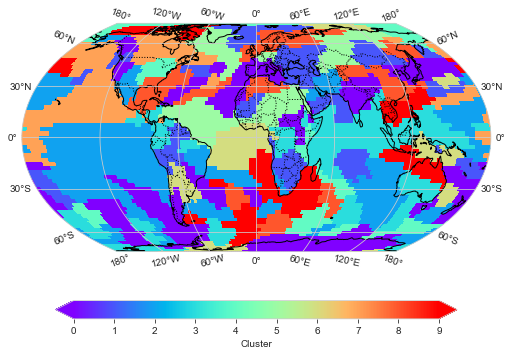

In [129]:
cluster_map = put.create_map_for_da(da=ds[var_name], data=clusterIds.reshape(dim_lat, dim_lon), name='Cluster')
im = put.plot_map(cluster_map, bar=True, 
                  cmap='rainbow',
                  central_longitude=0)